In [1]:
import os
import re
from io import BytesIO

import boto3
import pandas as pd
import s3fs
import timm
import torch
from PIL import Image
from huggingface_hub import login, hf_hub_download
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# get pretrained UNI model (H&E), 224x224

In [ ]:
login(add_to_git_credential=True)  # UAT at https://huggingface.co/settings/tokens

local_dir = "../models/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)
hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=False)

# instantiating via AutoModel didn't work for some reason, load state dict manually
model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
model.eval()

pytorch_model.bin:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

# load data sample to embed from s3


In [3]:
CELLPAINTING_BUCKET = 'panthera-cellpainting'
fs = s3fs.S3FileSystem()
fs.ls(CELLPAINTING_BUCKET + '/operetta_raw_data/241101_oncocross_mcf7')

['panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/',
 'panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/12h',
 'panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/24h',
 'panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/48h',
 'panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/6h',
 'panthera-cellpainting/operetta_raw_data/241101_oncocross_mcf7/72h']

In [18]:
class S3ImageDataset(Dataset):
    """
    Iterates over all .tiff in s3 bucket, returns each file as 2D tensor
    """

    def __init__(self, bucket_name, prefix='operetta_raw_data', suffix='.tiff', iterate_all=True):
        self.s3 = boto3.client('s3')
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.suffix = suffix
        self.iterate = iterate_all
        self.files = self._list_files()

    def _list_files(self):
        paginator = self.s3.get_paginator('list_objects_v2')
        page_iter = paginator.paginate(Bucket=self.bucket_name, Prefix=self.prefix)

        files = []
        for page in tqdm(page_iter):
            if 'Contents' in page:
                files.extend([obj['Key'] for obj in page['Contents'] if obj['Key'].endswith(self.suffix)])
            if not self.iterate:
                break
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_key = self.files[idx]
        response = self.s3.get_object(Bucket=self.bucket_name, Key=file_key)
        img_data = response['Body'].read()
        image = Image.open(BytesIO(img_data))
        return image


def parse_file_keys_to_manifest(files):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    rownum_to_alpha = dict(zip([x + 1 for x in range(len(alphabet))], alphabet))
    pattern = re.compile(r'r(\d{2})c(\d{2})f(\d{2})p(\d{2})-ch(\d)')

    data = []

    for path in files:
        segments = path.split("/")
        match = pattern.search(path)
        if match:
            row, col, field, plane, chan = match.groups()
            data.append({
                "file_key": path,
                'batch': segments[2],
                "row": rownum_to_alpha[int(row)],
                "col": int(col),
                "field": int(field),
                "plane": int(plane),
                "channel": int(chan),
            })

    manifest_df = pd.DataFrame(data)
    return manifest_df


manifest_fp = "../data/241101_oncocross_mcf7/manifest.tsv"
if not os.path.exists(manifest_fp):
    os.makedirs("../data/241101_oncocross_mcf7", exist_ok=True)
    dataset = S3ImageDataset(CELLPAINTING_BUCKET, 'operetta_raw_data/241101_oncocross_mcf7', iterate_all=True)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    manifest_df = parse_file_keys_to_manifest(dataset.files)
    manifest_df.to_csv("../data/241101_oncocross_mcf7/manifest.tsv", index=False, sep='\t')
else:
    manifest_df = pd.read_csv(manifest_fp, sep='\t')

65it [00:22,  2.95it/s]


In [17]:
manifest_df

,batch,plane,row,col,field,channel,file_key
0,12h,1,c,3,1,1,operetta_raw_data/241101_oncocross_mcf7/12h/on...
1,12h,1,c,3,1,2,operetta_raw_data/241101_oncocross_mcf7/12h/on...
2,12h,1,c,3,1,3,operetta_raw_data/241101_oncocross_mcf7/12h/on...
3,12h,1,c,3,1,4,operetta_raw_data/241101_oncocross_mcf7/12h/on...
4,12h,1,c,3,1,5,operetta_raw_data/241101_oncocross_mcf7/12h/on...
...,...,...,...,...,...,...,...
64795,72h,1,n,22,9,2,operetta_raw_data/241101_oncocross_mcf7/72h/on...
64796,72h,1,n,22,9,3,operetta_raw_data/241101_oncocross_mcf7/72h/on...
64797,72h,1,n,22,9,4,operetta_raw_data/241101_oncocross_mcf7/72h/on...
64798,72h,1,n,22,9,5,operetta_raw_data/241101_oncocross_mcf7/72h/on...


In [8]:
plate_map = pd.read_excel("../data/241101_oncocross_mcf7/plate_map.xlsx")
plate_map

,row,col,drug,dose
0,c,3,Tamoxifen,0.1
1,c,4,Tamoxifen,0.1
2,c,5,Tamoxifen,0.1
3,c,6,Tamoxifen,0.1
4,d,3,Tamoxifen,0.1
...,...,...,...,...
235,m,22,Vehicle,0.0
236,n,19,Vehicle,0.0
237,n,20,Vehicle,0.0
238,n,21,Vehicle,0.0


In [24]:
class S3StackedDataset(Dataset):
    def __init__(self, df, bucket_name, channels=(1, 2, 3, 4, 5, 6)):
        self.bucket_name = bucket_name
        df_filtered = df[df['channel'].isin(channels)]
        self.grouped = df_filtered.sort_values('channel').groupby(
            ['batch', 'plane', 'row', 'col', 'field']
        )['file_key'].apply(list).reset_index()
        self.s3_client = boto3.client('s3')
        self.s3fs = s3fs.S3FileSystem()

    def __len__(self):
        return len(self.grouped)

    def __getitem__(self, item):
        file_keys = self.grouped.iloc[item]['file_key']
        tensors = [self.load_image_as_tensor(file_key) for file_key in file_keys]
        stacked_tensor = torch.cat(tensors, dim=0)
        return stacked_tensor

    def load_image_as_tensor(self, file_key):
        with self.s3fs.open(self.bucket_name + "/" + file_key) as f:
            img_data = Image.open(f)
            return transforms.ToTensor()(img_data)


ds = S3StackedDataset(manifest_df, CELLPAINTING_BUCKET)

In [25]:
len(ds)

10800

In [26]:
x_img = ds[-1]

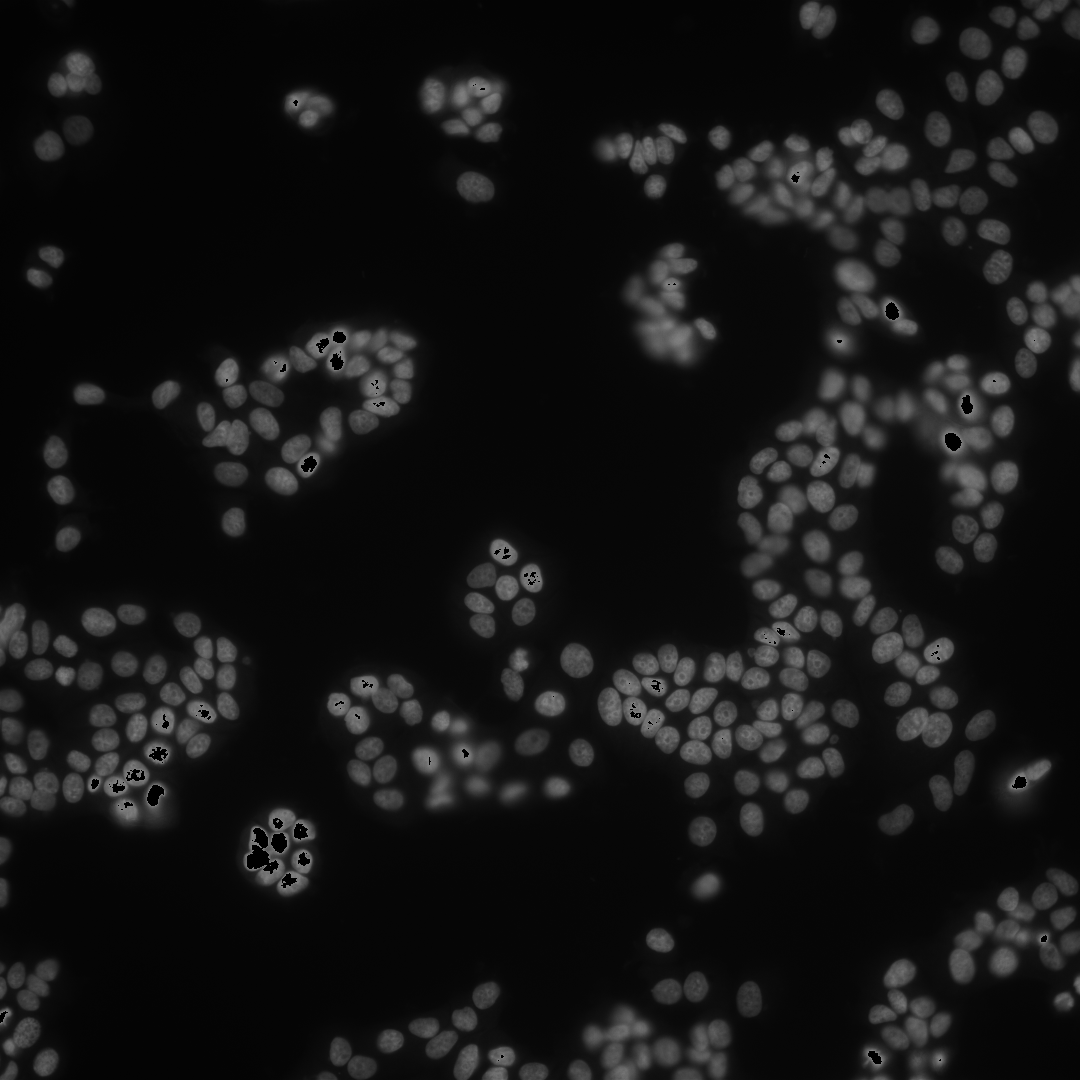

In [131]:
Image.fromarray(x_img.numpy()[2])

In [20]:
import falsecolor as fc
from falsecolor.process import ViewImage


def pseudo_he(cellpainting_image, nuc_idx=2, cyto_idx=1):
    """
    :param cellpainting_image: 6 channel tensor
    :param nuc_idx: index of nuclear stain
    :param cyto_idx: index of cyto stain
    :return: false color img
    """
    nuclei = cellpainting_image[nuc_idx].numpy()
    cyto = cellpainting_image[cyto_idx].numpy()

    nuc_bg = fc.getBackgroundLevels(nuclei)[1]
    cyto_bg = fc.getBackgroundLevels(cyto)[1]

    pseudo_he = fc.falseColor(nuclei, cyto, nuc_threshold=nuc_bg, cyto_threshold=cyto_bg)
    ViewImage(pseudo_he)

(<Figure size 600x400 with 1 Axes>, <Axes: >)

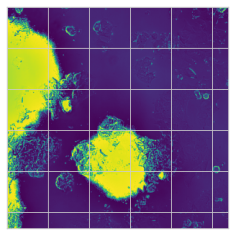

In [27]:
ViewImage(x_img[0])

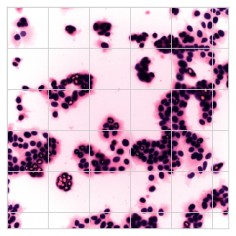

In [28]:
pseudo_he(x_img, )

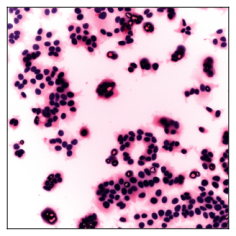

In [147]:
pseudo_he(ds[-2])

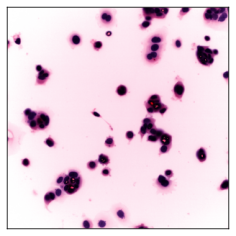

In [152]:
pseudo_he(ds[-100])

In [132]:
manifest_df[manifest_df['channel'] == 2]

,batch,plate,row,col,field,channel,file_key
1,12h,1,c,3,1,2,operetta_raw_data/241101_oncocross_mcf7/12h/oncocross_mcf7_12h__2024-11-01T22_39_14-Measurement 1/Images/r03c03f01p01-ch2sk1fk1fl1.tiff
7,12h,1,c,3,2,2,operetta_raw_data/241101_oncocross_mcf7/12h/oncocross_mcf7_12h__2024-11-01T22_39_14-Measurement 1/Images/r03c03f02p01-ch2sk1fk1fl1.tiff
13,12h,1,c,3,3,2,operetta_raw_data/241101_oncocross_mcf7/12h/oncocross_mcf7_12h__2024-11-01T22_39_14-Measurement 1/Images/r03c03f03p01-ch2sk1fk1fl1.tiff
19,12h,1,c,3,4,2,operetta_raw_data/241101_oncocross_mcf7/12h/oncocross_mcf7_12h__2024-11-01T22_39_14-Measurement 1/Images/r03c03f04p01-ch2sk1fk1fl1.tiff
25,12h,1,c,3,5,2,operetta_raw_data/241101_oncocross_mcf7/12h/oncocross_mcf7_12h__2024-11-01T22_39_14-Measurement 1/Images/r03c03f05p01-ch2sk1fk1fl1.tiff
...,...,...,...,...,...,...,...
64771,72h,1,n,22,5,2,operetta_raw_data/241101_oncocross_mcf7/72h/oncocross_mcf7_72h__2024-11-04T11_40_59-Measurement 1/Images/r14c22f05p01-ch2sk1fk1fl1.tiff
64777,72h,1,n,22,6,2,operetta_raw_data/241101_oncocross_mcf7/72h/oncocross_mcf7_72h__2024-11-04T11_40_59-Measurement 1/Images/r14c22f06p01-ch2sk1fk1fl1.tiff
64783,72h,1,n,22,7,2,operetta_raw_data/241101_oncocross_mcf7/72h/oncocross_mcf7_72h__2024-11-04T11_40_59-Measurement 1/Images/r14c22f07p01-ch2sk1fk1fl1.tiff
64789,72h,1,n,22,8,2,operetta_raw_data/241101_oncocross_mcf7/72h/oncocross_mcf7_72h__2024-11-04T11_40_59-Measurement 1/Images/r14c22f08p01-ch2sk1fk1fl1.tiff


In [133]:
embeddings = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_embeddings = model(batch)
        embeddings.append(batch_embeddings)
        break

  0%|          | 0/64800 [00:01<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.TiffImagePlugin.TiffImageFile'>